In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import Counter
import math

In [3]:
def puntoyComa(a):
  return '{:,}'.format(a).replace(',','~').replace('.',',').replace('~','.')

In [4]:
df = pd.read_excel("GraficoINDEC_todo.xlsx")
#sacamos años que no queremos tomar en cuenta
inicio = 2011
fin = 2021

mask = (df['Año'] >= inicio) & (df['Año'] <= fin)
df = df.loc[mask]

In [19]:
meses = df.Mes.tolist()
cantidadMuestrasMes = Counter(meses)
anios = df['Año']
anios = list(Counter(anios).keys())
v_expo = df.v_expo.tolist()
v_impo = df.v_impo.tolist()
p_expo = df.p_expo.tolist()
p_impo = df.p_impo.tolist()
q_expo = df.q_expo.tolist()
q_impo = df.q_impo.tolist()
media_v_expo = df.v_expo_media.tolist()
media_v_impo = df.v_impo_media.tolist()
media_p_expo = df.p_expo_media.tolist()
media_p_impo = df.p_impo_media.tolist()
media_q_expo = df.q_expo_media.tolist()
media_q_impo = df.q_impo_media.tolist()

In [6]:
#sacamos una lista con la cantidad acumulada de muestras por mes, mas adelante eso va a ser la posicion de los xticks
def acumula_muestras (distancias):
    distancias_acum = [0]
    for distancia in list(distancias.keys()):
        distancias_acum.append(distancias[distancia])
    distancias_acum = np.add.accumulate(distancias_acum).tolist()
    return distancias_acum

muestrasxMes_acum = acumula_muestras(cantidadMuestrasMes)

In [7]:
#Funcion que agrega NaN para correr las muestras horizontalmente
def corrimientoMuestras(datos, promedio):
  datos_corridos = segmenta(datos)
  meida_corrida = segmenta(promedio)
  for i in range(12):
    for x in range(muestrasxMes_acum[i]):
      datos_corridos[i].insert(x, None)
      meida_corrida[i].insert(x, None)
  return datos_corridos, meida_corrida

def segmenta(lista):
  #Separa las listas en una lista que contiene nuevas listas por mes
  listaMeses=[]

  for i in range(12):
    listaMeses.append(lista[muestrasxMes_acum[i]:muestrasxMes_acum[i+1]])
  
  return listaMeses

  #Extraemos solo los valores del 2021
def ultimoanio(datos):
  segmentado = segmenta(datos)
  ultianio = []
  for mes in segmentado:
    ultianio.append(mes[-1])
  return ultianio

In [8]:
def maxMinLista (val):
  segmentado = segmenta(val)
  extremosEstac = []
  for mes in segmentado:
    max_val = max(mes)
    max_idx = mes.index(max_val)
    min_val = min(mes)
    min_idx = mes.index(min_val)
    maxi = (max_val,max_idx)
    mini = (min_val,min_idx)
    media = sum(mes)/len(mes)

    #Cuartiles
    mes_sin_nan = []
    for v in mes:
      if(not math.isnan(v)):
        mes_sin_nan.append(v)
    qs = list(np.quantile(mes_sin_nan, [0.25, 0.5, 0.75]))
    q1s = qs[0]
    q2s = qs[1]
    q3s = qs[2]
    extremosEstac.append([maxi,mini,media,q1s,q2s,q3s])
  
  #Aca traspongo la matriz para que coincida con el formato de matplotlib
  extremosEstac = list(zip(*extremosEstac[::-1]))
  for i, ex in enumerate(extremosEstac):
    extremosEstac[i] = list(extremosEstac[i])
    extremosEstac[i].reverse()
  return extremosEstac

In [11]:
#determino el ancho de las columnas
col_width = []
muestrasxMes = list(cantidadMuestrasMes.values())
for muestra in muestrasxMes:
  col_width.append(muestra/sum(muestrasxMes))

In [12]:
def datosTabla(datos, ultiAnio):
    tabla = maxMinLista(datos)
    out = [[],[],[],[],[],[],[]]
    for max in tabla[0]:
        numeros = puntoyComa(round(max[0]))
        out[0].append(str(numeros)+" ("+anios[max[1]]+")")
    for min in tabla[1]:
        numeros = puntoyComa(round(min[0]))
        out[1].append(str(numeros)+" ("+anios[min[1]]+")")
    for prom in tabla[2]:
        if (math.isnan(prom)):
            prom = '--'
        else:
            numeros = puntoyComa(round(prom))
        out[2].append(str(numeros))
        
    #agregamos una fila con los valores del 2021
    for val in ultiAnio:
        if (math.isnan(val)):
            redondo = '--'
        else:
            redondo = puntoyComa(round(val))
        out[3].append(redondo)

    #agregamos los cuartiles

    for q1 in tabla[3]:
        out[4].append(puntoyComa(round(q1)))
    for q2 in tabla[4]:
        out[5].append(puntoyComa(round(q2)))
    for q3 in tabla[5]:
        out[6].append(puntoyComa(round(q3)))
        
    return out

In [13]:
def hace_tabla (ax, datos, col_width):
        
        lista_meses = list(cantidadMuestrasMes.keys())

        tabla = ax.table(
                datosTabla(datos, ultimoanio(datos)),
                colLabels=lista_meses,
                rowLabels=['Máx','Min','Prom','2021', 'Q1', 'Q2', 'Q3'],
                colWidths=col_width,
                bbox=[0, -0.28, 1, 0.275],
                )

        tabla.auto_set_font_size(False)
        tabla.set_fontsize(12)

        return tabla


In [14]:
def hace_grafo(ax1, dat1, med1, ax2, dat2, med2):
    # plotting the points
    datos_corridos1, media_corrida1 = corrimientoMuestras(dat1, med1)
    datos_corridos2, media_corrida2 = corrimientoMuestras(dat2, med2)


    for i in range(12):
        ax1.plot(datos_corridos1[i], color = "gold")
        ax1.plot(media_corrida1[i], color = "blueviolet")
    
    for i in range(12):
        ax2.plot(datos_corridos2[i], color = "blueviolet")
        ax2.plot(media_corrida2[i], color = "gold")
    #dibujo lineas verticales por mes
    for muestras in muestrasxMes_acum:
        ax1.axvline(muestras, color='grey', linestyle='--' )
        ax2.axvline(muestras, color='grey', linestyle='--' )
        
    ax1.set_xmargin(0)
    ax2.set_xmargin(0)
    ax1.set_xticks([])
    ax2.set_xticks([])
    
    #agrega las tablas
    hace_tabla(ax1, dat1, col_width)
    hace_tabla(ax2, dat2, col_width)

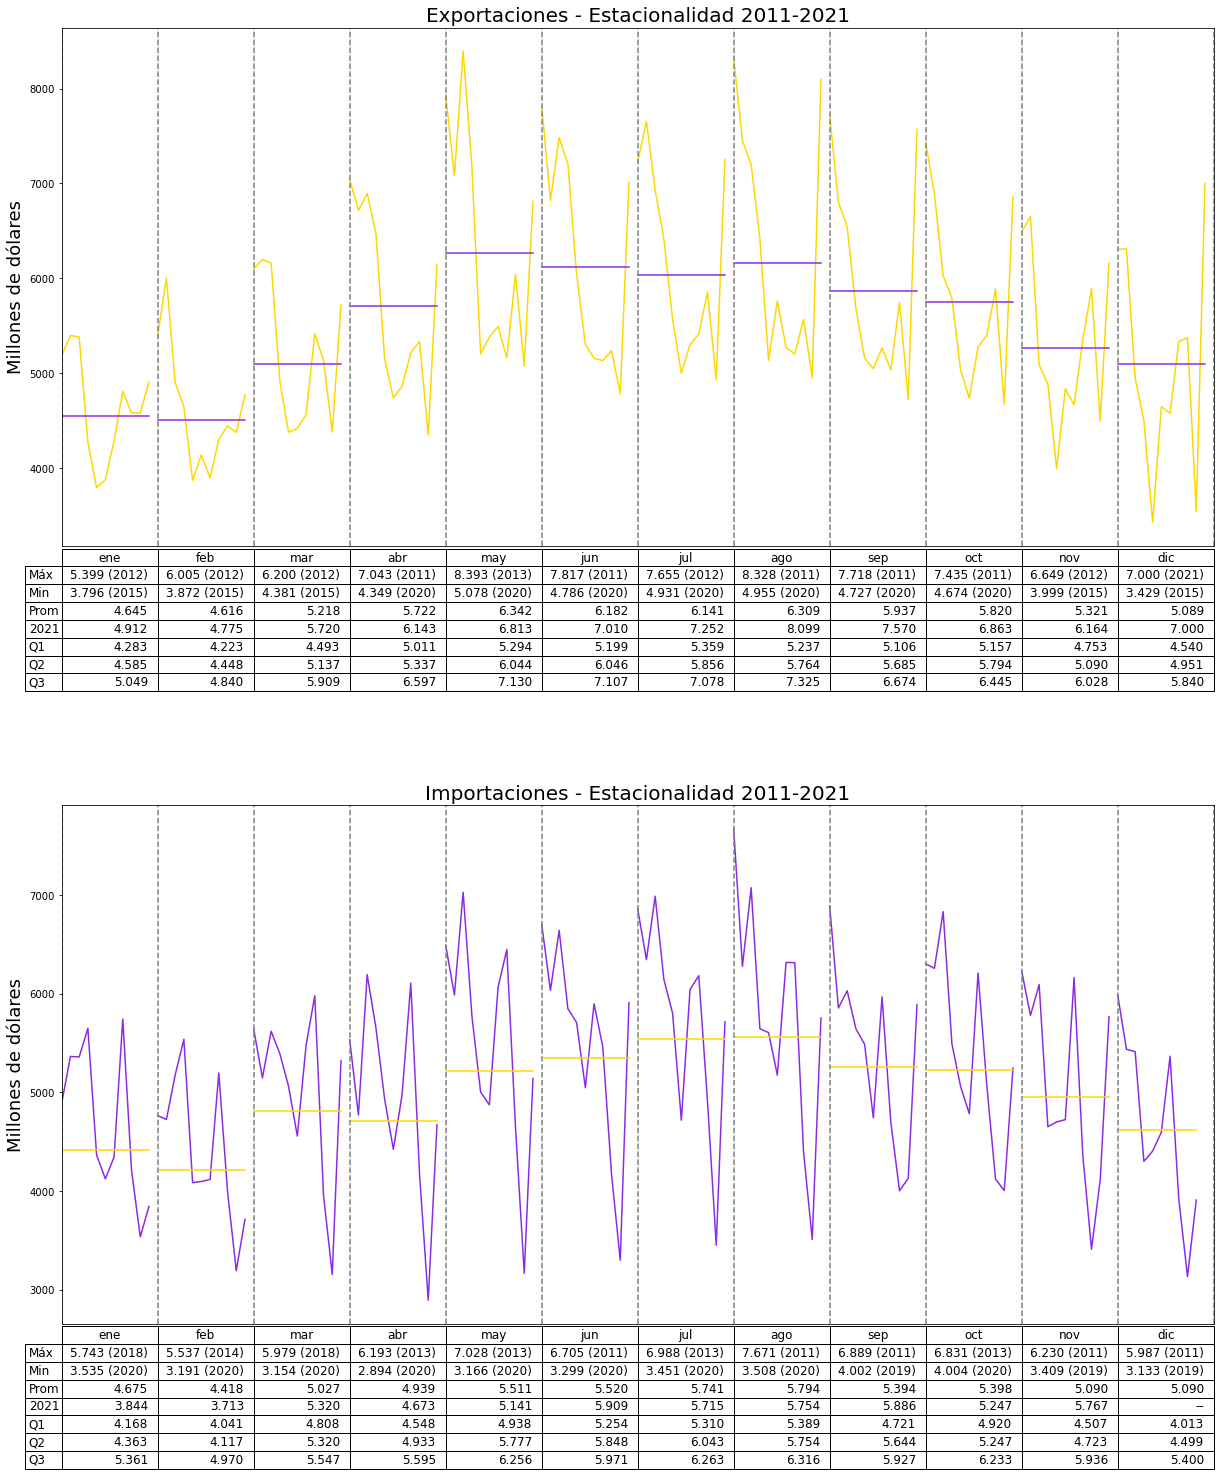

In [15]:
#Valores IMPO y EXPO
fig_valores, (ax_v_expo, ax_v_impo) = plt.subplots(2)
fig_valores.set_size_inches(20,20)

hace_grafo(ax_v_expo, v_expo, media_v_expo, ax_v_impo, v_impo, media_v_impo)

#Algunos ajustes de tamaño de letra etc
ax_v_expo.set_ylabel('Millones de dólares', fontsize = 18)
ax_v_impo.set_ylabel('Millones de dólares', fontsize = 18)
ax_v_expo.set_title(f'Exportaciones - Estacionalidad {inicio}-{fin}', fontsize = 20)

ax_v_impo.set_title(f'Importaciones - Estacionalidad {inicio}-{fin}', fontsize = 20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.5)


#Imprimo

plt.show()


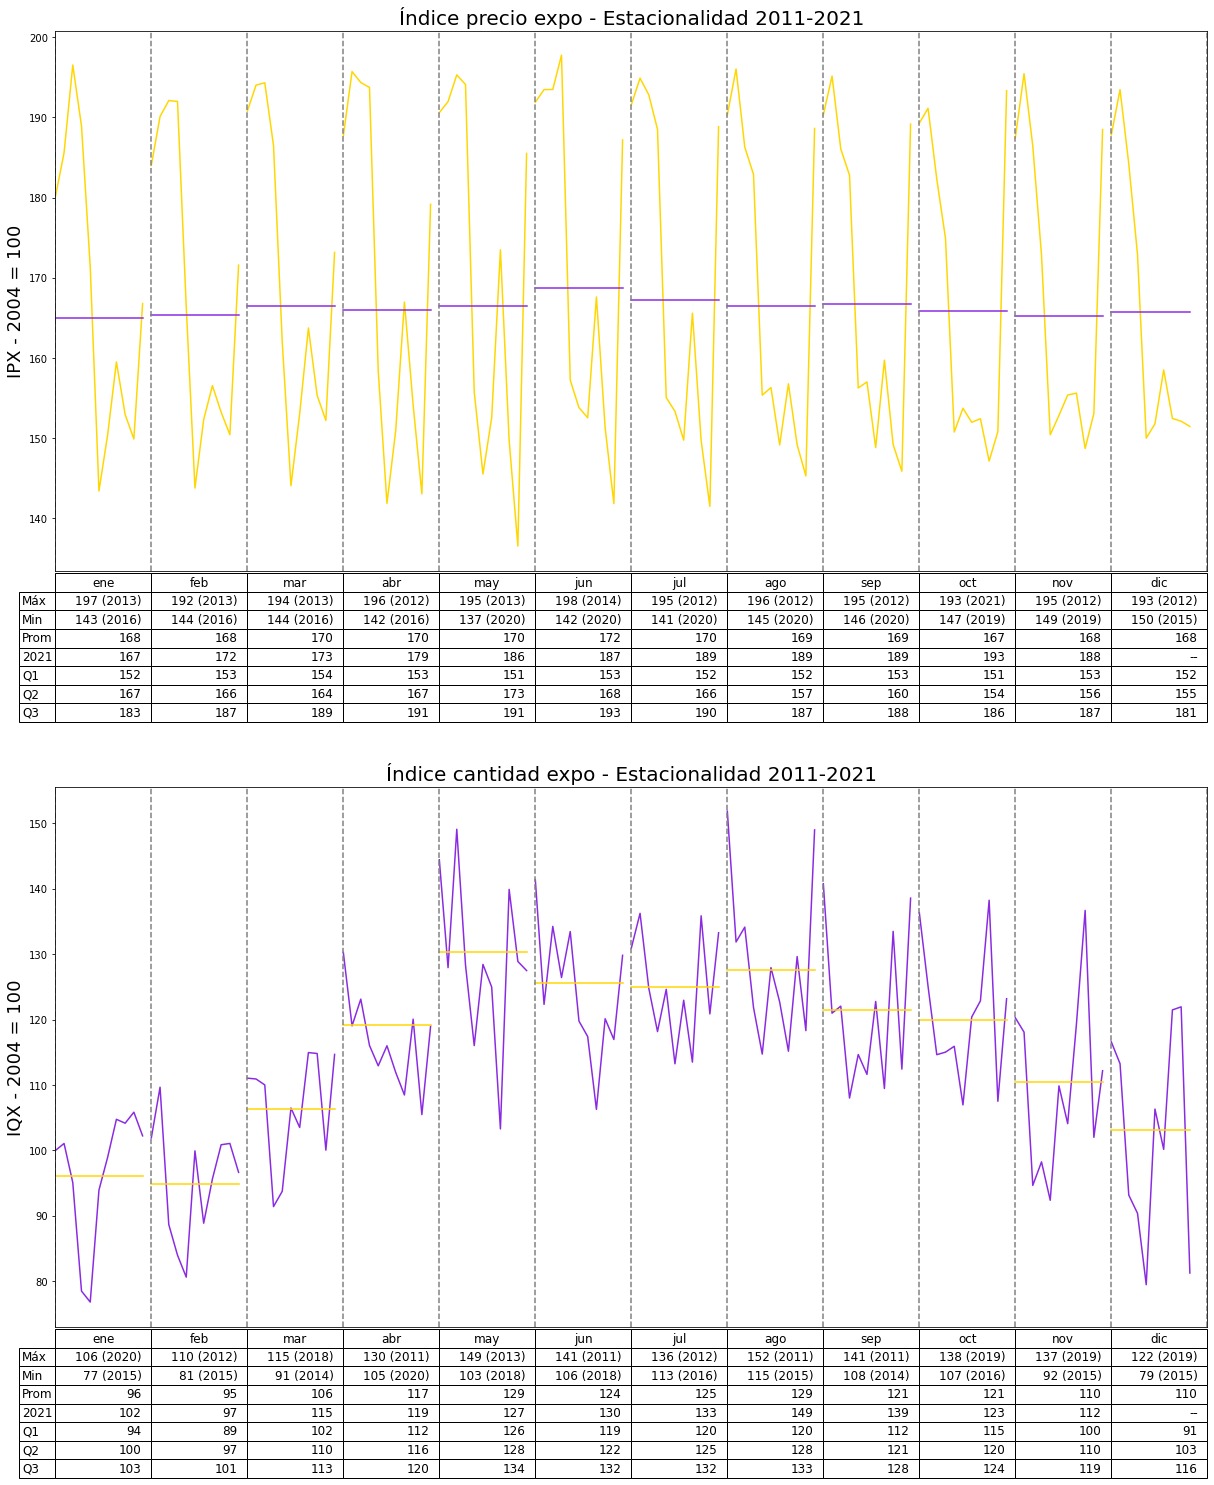

In [16]:
#Precios y cantidades EXPO
#Valores IMPO y EXPO
fig_i_expo, (ax_p_expo, ax_q_expo) = plt.subplots(2)
fig_i_expo.set_size_inches(20,20)

hace_grafo(ax_p_expo, p_expo, media_p_expo, ax_q_expo, q_expo, media_q_expo)

#Algunos ajustes de tamaño de letra etc
ax_p_expo.set_ylabel('IPX - 2004 = 100', fontsize = 18)
ax_q_expo.set_ylabel('IQX - 2004 = 100', fontsize = 18)


ax_p_expo.set_title(f'Índice precio expo - Estacionalidad {inicio}-{fin}', fontsize = 20)

ax_q_expo.set_title(f'Índice cantidad expo - Estacionalidad {inicio}-{fin}', fontsize = 20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.4)


#Imprimo

plt.show()

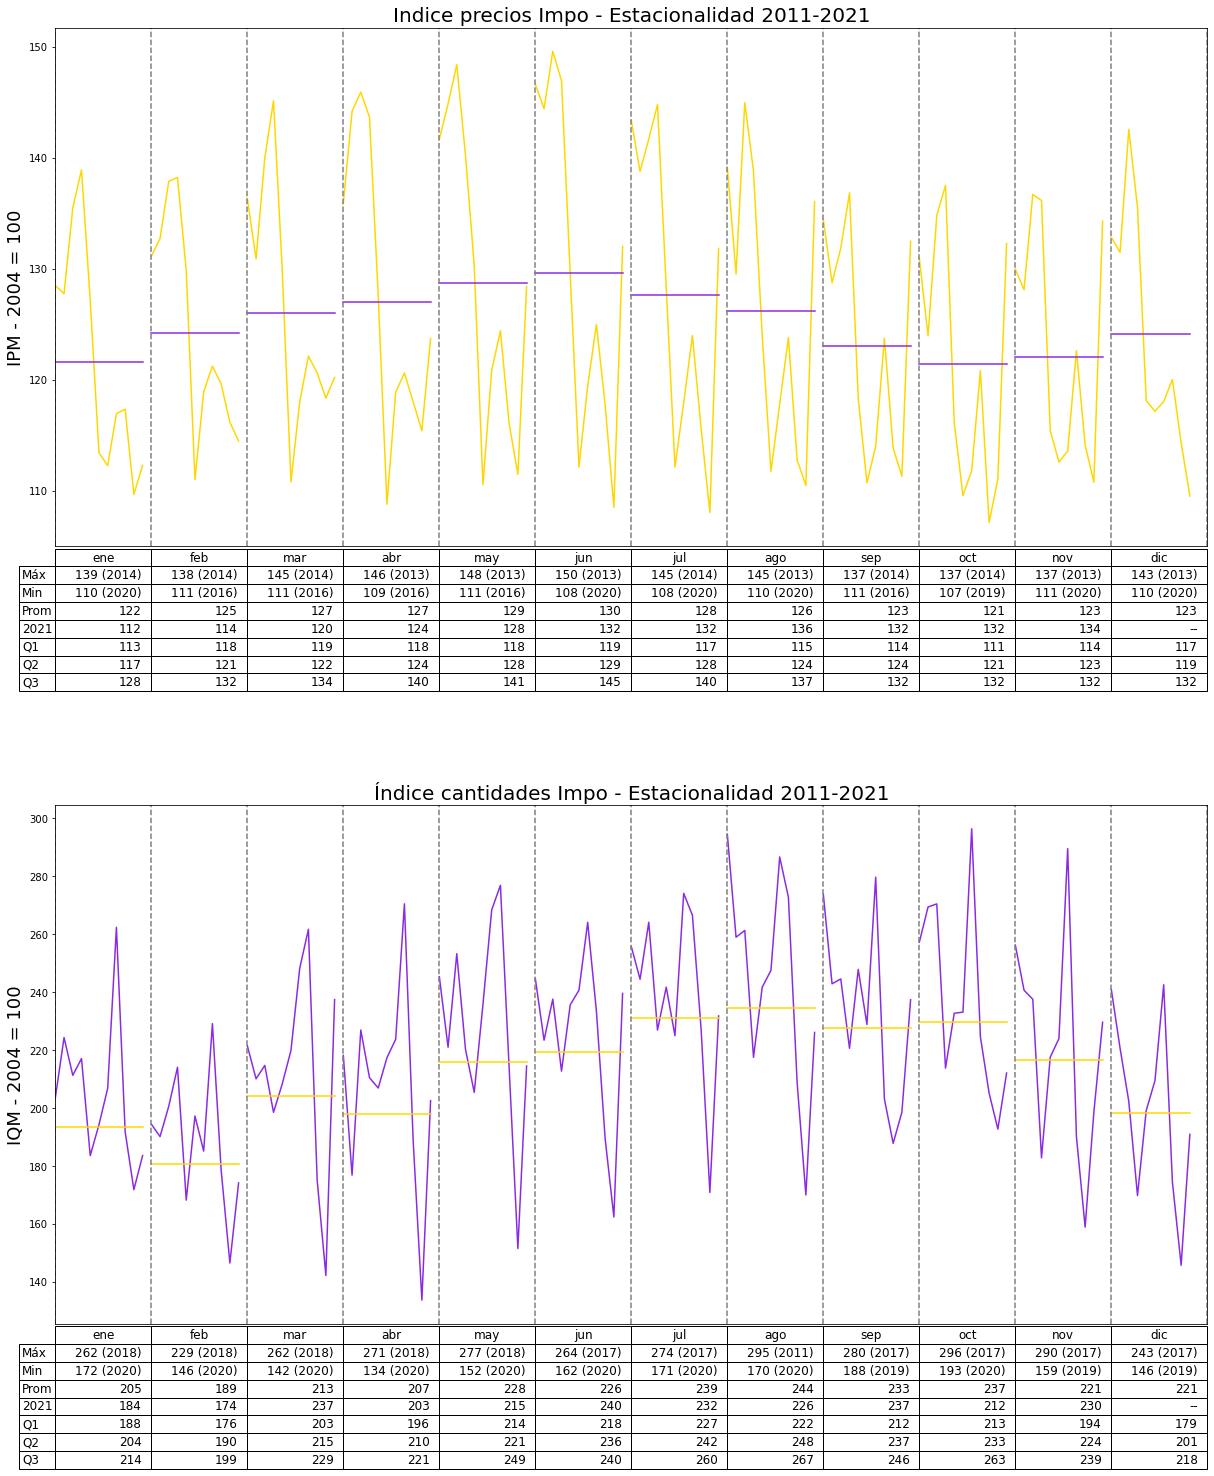

In [17]:
#Precios y cantidades IMPO

fig_i_impo, (ax_p_impo, ax_q_impo) = plt.subplots(2)
fig_i_impo.set_size_inches(20,20)

hace_grafo(ax_p_impo, p_impo, media_p_impo, ax_q_impo, q_impo, media_q_impo)

#Algunos ajustes de tamaño de letra etc
ax_p_impo.set_ylabel('IPM - 2004 = 100', fontsize = 18)
ax_q_impo.set_ylabel('IQM - 2004 = 100', fontsize = 18)
ax_p_impo.set_title(f'Indice precios Impo - Estacionalidad {inicio}-{fin}', fontsize = 20)

ax_q_impo.set_title(f'Índice cantidades Impo - Estacionalidad {inicio}-{fin}', fontsize = 20)

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=1, 
                    wspace=0.4, 
                    hspace=0.5)


#Imprimo

plt.show()

In [18]:
fig_valores.savefig('Estacionalidad de valores Impo-Expo.pdf', transparent=False, dpi=300, bbox_inches = "tight")
fig_i_expo.savefig('Estacionalidad de IPX-IQX.pdf', transparent=False,dpi=300, bbox_inches = "tight")
fig_i_impo.savefig('Estacionalidad de IPM-IQM.pdf', transparent=False,dpi=300, bbox_inches = "tight")